In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from albumentations import CLAHE

### CALIBRATE WITH CHESSBOARD

In [5]:
def calibrate(nx, ny):
    """
    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    """
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    img = mpimg.imread('../camera_cal/calibration2.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:

        imgpoints.append(corners)
        objpoints.append(objp)
        resp, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        offset = 100
        image_size = (gray.shape[1], gray.shape[0])
        dst = np.float32([[offset, offset],
                        [image_size[0]-offset, offset],
                        [image_size[0]-offset, image_size[1]-offset],
                        [offset, image_size[1]-offset]])
        return mtx, dist

Hi :) to check and see results of calibrate function click here [visit this notebook](Calibrate%20Camera.ipynb)

### UNDISTORT IMAGE

Text(0.5, 1.0, 'ORIGIN_IMAGE')

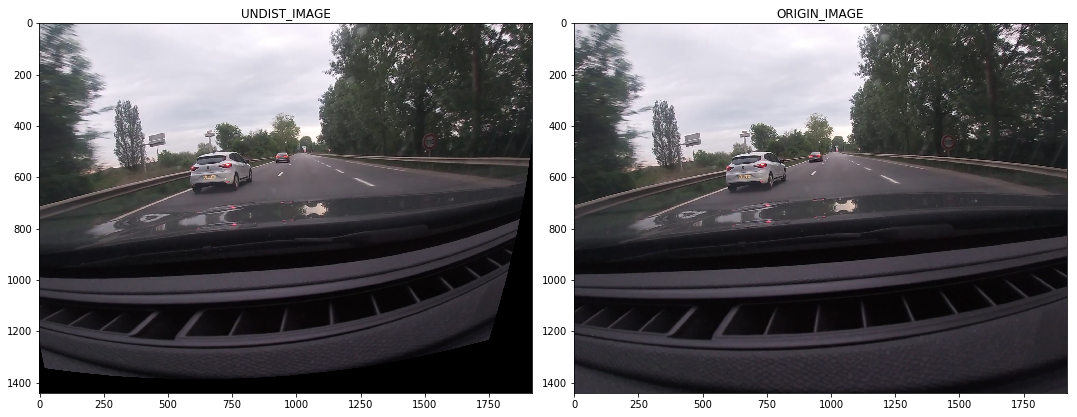

In [6]:
image = '../data/test/1589132066.566491.jpg'
img = mpimg.imread(image)

def undist(img):
    """
    Apply a distortion correction to raw images.
    """
    mtx, dist = calibrate(9, 6)
    undist_pic = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist_pic, img

undist_pic, img = undist(img)
fig, axs = plt.subplots(1, 2, figsize=(15, 20))
fig.tight_layout()
axs[0].imshow(undist_pic)
axs[0].set_title("UNDIST_IMAGE")
axs[1].imshow(img)
axs[1].set_title("ORIGIN_IMAGE")


### WARPED IMAGE

In [7]:
def warp(img):
    """
    Apply a perspective transform to rectify binary image ("birds-eye view").
    """
    img_size = (img.shape[1], img.shape[0])
    offset = 100
    src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + offset],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + offset]])
    dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

Same thing here check examples and see results of warp function click here [visit this notebook](Warp.ipynb)

### HERE DIRECT COMBINE SOBEL METHOD AND Hue Lightness Saturation

In [8]:
def abs_sobel_thresh(G, B, orient='x', thresh_min=3, thresh_max=(0, 255)):
    """
    Calculate directional gradient
    """
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(B, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(G, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_max[0]) & (scaled_sobel <= thresh_max[1])] = 1
    
    return binary_output

def mag_thresh(G, B, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Calculate gradient magnitude
    """
    sobelx = cv2.Sobel(B, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(G, cv2.CV_64F, 0, 1)
    cal = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(cal)/255
    cal = (cal/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(cal)
    binary_output[(cal >= mag_thresh[0]) & (cal <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(G, B, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Calculate gradient direction
    """
    sobelx = cv2.Sobel(B, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(G, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    atan = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(atan)
    binary_output[(atan >= thresh[0]) & (atan <= thresh[1])] = 1
    
    return binary_output

def augment_and_clahe(aug, image):
    """
    Use Clahe method
    """
    image = aug(image=image)['image']
    return image

In [50]:
def combine_sobel_hls_threshold(img):
    """
    Combining Sobel method and gradient's magnitude and direction
    """
    ksize, bright = 3, 0
    image = np.copy(img)
    # Clahe 
    aug = CLAHE(p=bright)
    clahe = augment_and_clahe(aug, image)
    
    sx_thresh=(45, 255)
    s_thresh=(130, 255)
    abso_sobelx = (10, 255)
    abso_sobely = (2, 255)
    mag_tresh = (90, 255)
    dir_thresh=(0.7, 1.2)
    
    hls = cv2.cvtColor(clahe, cv2.COLOR_RGB2HLS)
    plt.imshow(hls)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    
    gradx = abs_sobel_thresh(l_channel, s_channel, orient='x', thresh_max=(abso_sobelx[0], abso_sobelx[1]))
    grady = abs_sobel_thresh(l_channel, s_channel, orient='y', thresh_max=(abso_sobely[0], abso_sobely[1]))
    mag_binary = mag_thresh(l_channel, s_channel, ksize, mag_thresh=(mag_tresh[0], mag_tresh[1]))
    dir_binary = dir_threshold(l_channel, s_channel, ksize, thresh=(dir_thresh[0], dir_thresh[1]))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((mag_binary == 1) & (dir_binary == 1)) | ((gradx == 1) & (grady == 1))] = 1
    #  ((s_binary == 1) & (sxbinary == 1)) | 
    
    return combined_binary

### FIND LANE & CALCUL CURVE LANE LINES

In [51]:
ym_per_pix = 30/720
xm_per_pix = 3.7/700
def mesure_curve(left_fit_cr, right_fit_cr, ploty):
    """
    Determine curvature of lines.
    """
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5 / np.absolute(2*right_fit_cr[0]))
    
    return left_curverad, right_curverad

In [52]:
def find_lane_pixels(binary_warped, nwindows=9, margin=125, minpix=20):
    """
    Detect lane pixels and fit to find the lane boundary.
    """
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    yMax = out_img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
   
    window_height = np.int(binary_warped.shape[0]//nwindows)
  
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
  
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

   
    for window in range(nwindows):
        
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin  
        
        #Draw rectangle
        
        
        
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
         
        pass # Remove this when you add your function

   
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        print(ValueError)
        exit()
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    
    left_curverad, right_curverad = mesure_curve(left_fit_m, right_fit_m, ploty)
    
#     if left_curverad 
    
    #calcul lines
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] #LEFT
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] #RIGHT
    
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx,\
            ploty, left_curverad, right_curverad, out_img

### DISPLAY INFO POSITION VEHICLE AND CURVATURE LANE LINES

In [53]:
def position_info(img, output):
    """
    Return vehicle position with respect to center and display curvature information lines.
    """
    
    Minv, warped = combo_calibrate_wrap(img)
    _, _, _, _, _, _, left_fit_m, right_fit_m, _, _, _, left_curverad, right_curverad, _ = find_lane_pixels(warped)
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicle_center = xMax / 2
    line_left                   = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    line_right                  = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    line_middle                 = line_left + (line_right - line_left)/2
    diff_from_vehicle_and_lines = line_middle - vehicle_center
    if diff_from_vehicle_and_lines > 0:
        message = '{:.2f} m left'.format(diff_from_vehicle_and_lines)
    else:
        message = '{:.2f} m right'.format(-diff_from_vehicle_and_lines)
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, 2, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, 2, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 2, fontColor, 2)
    return output

### HERE REGROUPE ALL FUNCTION

In [54]:
#TODO Important : try to optimise these cells

In [55]:
def combo_calibrate_wrap(img):
    
    combined_img = combine_sobel_hls_threshold(img)
    M, Minv, warped = warp(combined_img)
    
    return Minv, warped

In [56]:
def calculate_lanes(img):
    
    Minv, warped = combo_calibrate_wrap(img)
    color_warp = np.zeros_like(img).astype(np.uint8)
    leftx, lefty, rightx, righty, left_fit, right_fit,_, _, left_fitx, right_fitx, ploty, _, _, out_img = find_lane_pixels(warped)
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0))
    
    #result
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    
    return out_img, newwarp

In [57]:
def all_process(img):
    
    out_img, newwarp = calculate_lanes(img)
    combo_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
#     output1 = cv2.resize(newwarp,(640, 360), interpolation = cv2.INTER_AREA)
#     output2 = cv2.resize(out_img,(640, 360), interpolation = cv2.INTER_AREA)
    
#     # Create an array big enough to hold both images next to each other.
#     vis = np.zeros((720, 1280+640, 3))
    
#     # Copy both images into the composed image.
#     vis[:720, :1280,:] = combo_img
#     vis[:360, 1280:1920,:] = output1
#     vis[360:720, 1280:1920,:] = output2
    
    
    position_info(img, combo_img)
    
    return combo_img

### DISPLAY IMAGES

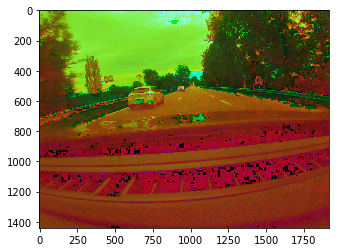

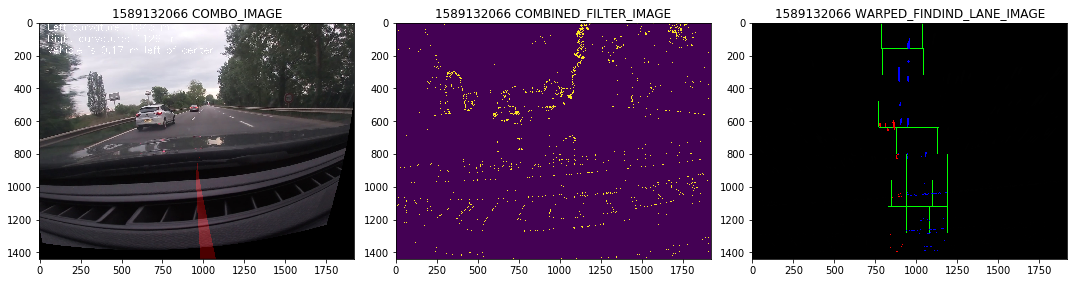

In [58]:
def img():
    
    paths = os.getcwd()+'/test_images'
    files = os.listdir(paths)
    
    for num, x in enumerate(files):
        
        image = mpimg.imread('./test_images/'+x)
        lane_image = np.copy(image)
        undist_pic, img = undist(lane_image)
        
        combo_img = all_process(undist_pic)
        out_img, newwarp = calculate_lanes(lane_image)
        combined_img = combine_sobel_hls_threshold(img)
        
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 20))
        fig.tight_layout()
        axs[0].imshow(combo_img)
        axs[0].set_title(x.split('.')[0]+" COMBO_IMAGE")
        axs[1].imshow(combined_img)
        axs[1].set_title(x.split('.')[0]+" COMBINED_FILTER_IMAGE")
        axs[2].imshow(out_img)
        axs[2].set_title(x.split('.')[0]+" WARPED_FINDIND_LANE_IMAGE")
        
        
img()

### DISPLAY VIDEOS

In [ ]:
from moviepy.editor import VideoFileClip

In [ ]:
project_video_name = 'project_video.mp4'

def vid():
    
    white_output = 'output_videos/'+project_video_name
    clip1 = VideoFileClip('test_videos/'+project_video_name)
    white_clip = clip1.fl_image(all_process) 
    %time white_clip.write_videofile(white_output, audio=False)
vid()

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('./output_videos/'+project_video_name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" style="width:100%;" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
def combine_sobel_hls_threshold_test(img, ksize, mag_low, mag_high, X_low, X_high,Y_low, Y_high,\
                                hls_low1, hls_high1, dir_low, dir_high, hls_low, hls_high, bright):
    """
    Combining Sobel method and gradient's magnitude and direction
    """
    
    image = np.copy(img)
#     print(image.shape)

    aug = CLAHE(p=bright)
    clahe = augment_and_clahe(aug, image)
    # Convert to HLS color space and separate the V channel
    s_thresh=(hls_low, hls_high)
    sx_thresh=(hls_low1, hls_high1)
    
    hls = cv2.cvtColor(clahe, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    
    gradx = abs_sobel_thresh(l_channel, s_channel, orient='x', thresh_max=(X_low, X_high))
    grady = abs_sobel_thresh(l_channel, s_channel, orient='y', thresh_max=(Y_low, Y_low))
    mag_binary = mag_thresh(l_channel, s_channel, ksize, mag_thresh=(mag_low, mag_high))
    dir_binary = dir_threshold(l_channel, s_channel, ksize, thresh=(dir_low, dir_high))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | ((mag_binary == 1) & (dir_binary == 1)) | ((gradx == 1) & (grady == 1))] = 1
    
    return combined_binary






def interactive_mask(ksize, mag_low, mag_high,X_low, X_high,Y_low, Y_high,\
                     hls_low1, hls_high1, dir_low, dir_high, hls_low, hls_high, bright):
    
    
    paths = os.getcwd()+'/test_images'
    files = os.listdir(paths)
    
    for num, x in enumerate(files):
        
        image = mpimg.imread('./test_images/'+x)
        lane_image = np.copy(image)
        mtx, dist = calibrate(9, 6)
        image = cv2.undistort(lane_image, mtx, dist, None, mtx)
        ksize, mag_low, mag_high, X_low, X_high,Y_low, Y_high,\
#         hls_low1, hls_high1, dir_low, dir_high, hls_low, hls_high, bright = 3, 60, 255, 12, 255, 7, 255, 50, 255, 0.6, 1.0, 175, 255, -0.2

        combined = combine_sobel_hls_threshold_test(image, ksize, mag_low, mag_high,X_low, X_high,Y_low, Y_high,\
                                               hls_low1, hls_high1, dir_low, dir_high, hls_low, hls_high, bright)
#         plt.figure(figsize=(10,10))
#         plt.imshow(combined,cmap='gray')
        
        fig, axs = plt.subplots(figsize=(5, 10))
        fig.tight_layout()
        axs.imshow(combined)
        
        

        
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display    

In [ ]:
interact(interactive_mask, ksize=(1,7,2), mag_low=(0,255), mag_high=(0,255),\
         X_low=(0,255),X_high=(0,255), Y_low=(0,255),Y_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), hls_low1=(0,255), hls_high1=(0,255), bright=(-1.0,1.0))
# 3, 90, 255, 12, 255, 7, 255, 50, 255, 0.6, 1.0, 175, 255, 0.0

#1,90,200,20,200,10,200,50,200,0.6,1.3,150,255,0 = VRAI 1/2
#1,10,10,20,200,10,200,11,255,0.6,1.2,1,1,0 = VRAI pour l'ombre

3,150,180,20,200,150,200,30,255,0.7,1.2,150,250,0
3,90,200,20,200,150,255,90,100,0.5,1.5,150,255,0


3, 90, 255, 10, 255, 10, 255, 90, 100, 0.5, 1.5, 150, 255, 0